In [1]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.model import Discriminator
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from torch import optim
from torch import nn
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
import seaborn
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import sys
FIGSIZE=(3,3)               
rcParams['figure.figsize']=FIGSIZE

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
class Args(dict):
    def __init__(self, *args, **kwargs):
        super(Args, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [3]:
def calculate_metrics(predictions, labels):
    # Convert predictions and labels to numpy arrays
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')  # Change 'weighted' to 'micro', 'macro', or 'samples'
    recall = recall_score(labels, predictions, average='weighted')  # Change 'weighted' to 'micro', 'macro', or 'samples'
    f1 = f1_score(labels, predictions, average='weighted')  # Change 'weighted' to 'micro', 'macro', or 'samples'

    # Calculate confusion matrix
    cm = confusion_matrix(labels, predictions)

    return accuracy, precision, recall, f1, cm

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def initalize_stargan(config_dict, number):
    """Initialize the starGANv1 model 

    Args:
        path (str): path to the .yml configuration file for the experiment 
        number (int): number of the iteration to reload
    """
    sys.path = sys.path[:6]
    sys.path.append('/home/icb/alessandro.palma/environment/IMPA/stargan/')
    from solver_stargan import Solver as solver_stargan
    args_stargan = Args(config_dict)
    solver = solver_stargan(args_stargan)
    solver.restore_model(number)
    return solver

# stargan generated 

In [7]:
args_stargan = {"batch_size": 8,
        "val_batch_size": 10,
        "num_workers": 6,
        "image_path": "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1",
        "data_index_path": "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1/metadata/rxrx1_df.csv",
        "embedding_path": "",
        "augment_train": True,
        "normalize": True,
        "balanced": True,
        "batch_correction": True,
        "batch_key": "BATCH",
        "dim_in": 6,
        "c_dim": 3,
        "image_size": 96,
        "g_conv_dim": 64,
        "d_conv_dim": 64,
        "g_repeat_num": 6,
        "d_repeat_num": 5,
        "lambda_cls": 1,
        "lambda_rec": 10,
        "lambda_gp": 10,
        "num_iters": 300000,
        "num_iters_decay": 100000,
        "g_lr": 0.0001,
        "d_lr": 0.0001,
        "n_critic": 5,
        "beta1": 0.5,
        "beta2": 0.999,
        "resume_iters": None,
        "mode": "train",
        "use_tensorboard": False,
        "log_dir": "/lustre/groups/ml01/workspace/alessandro.palma/stargan/recursion_batch/logs",
        "model_save_dir": "/lustre/groups/ml01/workspace/alessandro.palma/stargan/recursion_batch/models",
        "sample_dir": "/lustre/groups/ml01/workspace/alessandro.palma/stargan/recursion_batch/samples",
        "result_dir": "/lustre/groups/ml01/workspace/alessandro.palma/stargan/recursion_batch/results",
        "log_step": 500,
        "sample_step": 500,
        "model_save_step": 5000,
        "lr_update_step": 1000,
        "mol_list": None,
        "ood_set": None,
        "dataset_name": "recursion",
        "trainable_emb": True, 
        "latent_dim": 10,
        "pert_modelling": False, 
        "n_channels": False,
        "dataset_name": "rxrx1"
}

args_stargan = Args(args_stargan)
dataloader = CellDataLoader(args_stargan)
solver = initalize_stargan(args_stargan, 300000)

stargan_prediction_set = [dataloader.train_dataloader(), 
                              dataloader.val_dataloader()]

None
None
Lodading the data...
Loading images...
Training with 3 mols
Successfully loaded the data
Generator(
  (main): Sequential(
    (0): Conv2d(9, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

## Initialize Discriminator

In [9]:
classifier_net = Discriminator(img_size=96,
                                  num_domains=dataloader.n_mol, 
                                  max_conv_dim=512, 
                                  in_channels=6, 
                                  dim_in=64,
                                  multi_task=False)

In [10]:
class Classifier(LightningModule):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x, None)

    def training_step(self, batch, batch_idx):
        X, labels = batch["X"], batch["mol_one_hot"].argmax(1)
        outputs = self.model(X, None)
        loss = self.criterion(outputs, labels)
        return loss

    def val_step(self, batch, batch_idx):
        X, labels = batch["X"], batch["mol_one_hot"].argmax(1)
        outputs = self.model(X, None)
        loss = self.criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).sum().item() / len(labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.val_step(batch, batch_idx)
        return loss
        
    def test_step(self, batch, batch_idx):
        loss = self.val_step(batch, batch_idx)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)


In [11]:
classifier = Classifier(classifier_net, 0.0001)
classifier.to("cuda")

Classifier(
  (model): Discriminator(
    (conv): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResBlk(
        (actv): LeakyReLU(negative_slope=0.2)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1x1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (2): ResBlk(
        (actv): LeakyReLU(negative_slope=0.2)
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1x1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (3): ResBlk(
        (actv): LeakyReLU(negative_slope=0.2)
        (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1,

In [12]:
classifier.load_state_dict(torch.load("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/batch_classifier_results/rxrx1/best_model.ckpt")["state_dict"])

<All keys matched successfully>

In [17]:
# true_labels_generated= []
# predicted_labels_generated = []
# for set in generated_prediction_set:
#     for batch in tqdm(set):
#         with torch.no_grad():
#             X = batch["X"].to("cuda")
#             y = torch.zeros(X.shape[0], 3).long().cuda()
#             y[:, 0] = 1
#             X_generated = solver.G(X, y)
#             pred = classifier(X_generated)
#             predicted_labels_generated.append(pred.argmax(1).cpu())
#             true_labels_generated.append(batch["mol_one_hot"].argmax(1).cpu())

In [ ]:
# true_labels_generated=torch.cat(true_labels_generated)
# predicted_labels_generated=torch.cat(predicted_labels_generated)

In [ ]:
# calculate_metrics(true_labels_generated, predicted_labels_generated)

## Plot results

In [18]:
# freq_after = np.unique(predicted_labels_generated.tolist(), return_counts=True)

# batch = list(batch_after)
# batch = [f"batch {key}" for key in batch]
# freq = list(freq_after[1]/np.sum(freq_after))

# method = ["after correction"]*len(batch)

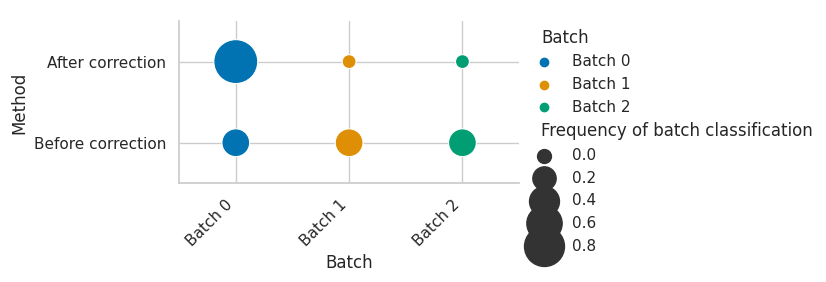

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
to_plot = pd.DataFrame({
    "Batch": ["Batch 0", "Batch 1", "Batch 2", "Batch 0", "Batch 1", "Batch 2"],
    "Frequency of batch classification": [0.33, 0.33, 0.33, 0.99, 0.00, 0.00],
    "Method": ["Before correction", "Before correction", "Before correction",
               "After correction", "After correction", "After correction"]
})

# Set the style for a cleaner appearance
sns.set(style="whitegrid")


# Plot the dot plot
sns.relplot(data=to_plot,
            x="Batch",
            y="Method",  # Size of dots based on frequency
            hue="Batch",   # Color of dots based on frequency
            palette="colorblind",  # You can choose any colormap you prefer # Separate points for each hue level
            alpha=1,
            sizes=(100, 1000),
            size="Frequency of batch classification", 
           units="Batch", 
           height=2.5, aspect=2.5, legend="brief")    # Adjust transparency for better visualization


plt.xticks(rotation=45, ha='right')
plt.xlim(-0.5, 2.5)  # Adjusted x-axis limits
plt.ylim(-0.5, 1.5)  # Adjusted y-axis limits
plt.savefig('/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/plots/classifier_performance.svg',
           dpi=300, bbox_inches='tight', format='svg')
plt.show()

In [3]:
to_plot.to_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/source_data/figure_3b.csv")

In [ ]:
# # Set the style for a cleaner appearance
# sns.set(style="whitegrid")

# # Plot the dot plot
# sns.relplot(data=to_plot,
#             x="Batch",
#             y="Method",
#             hue="Freq",
#             palette="viridis",
#             alpha=1,
#             sizes=(100, 1000),
#             size="Freq", 
#             units="Batch", 
#             height=5, aspect=1.5, legend="brief")  # Adjusted aspect and height
# plt.xticks(rotation=45, ha='right')
# plt.xlim(-0.5, 2.5)  # Adjusted x-axis limits
# plt.ylim(-0.5, 1.5)  # Adjusted y-axis limits
# # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjusted legend position
# plt.show()